In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import re
import os

path = "TODO replace with path to results folder"
file_paths = {"GCN": "save_results_tuning_1024_gcn_baseline_masking_vae_weights_elastic_nullingout.pkl",
              "SpaRef": "save_results_tuning_1024_sparef_gcn_baseline_masking_vae_weights_elastic_nullingout.pkl"
            }

full_paths = {k: os.path.join(path, v) for k, v in file_paths.items()}

In [3]:
# Creating DataFrame with appropriate column names
columns = ['MLP_layers', 'GNN_layers', 'num_head', 'hidden_dim', 'dropout', 'loss_lambda', 'weights_lambda', 'weights_elastic']
additional_columns = ['Perc0_AvgAcc', 'Perc0_StdAcc', 'Perc0_AvgAUC', 'Perc0_StdAUC',
                      'Perc07_AvgAcc', 'Perc07_StdAcc', 'Perc07_AvgAUC', 'Perc07_StdAUC',
                      'Perc08_AvgAcc', 'Perc08_StdAcc', 'Perc08_AvgAUC', 'Perc08_StdAUC',
                      'Perc095_AvgAcc', 'Perc095_StdAcc', 'Perc095_AvgAUC', 'Perc095_StdAUC',
                      'Perc09_AvgAcc', 'Perc09_StdAcc', 'Perc09_AvgAUC', 'Perc09_StdAUC',
                      'MaxAvgAcc', 'MaxAvgAUC',
                      'Perc0_TreatmentAcc', 'Perc0_TreatmentAUC', 'Perc0_ScannerAcc', 'Perc0_ScannerAUC',
                      'Perc07_TreatmentAcc', 'Perc07_TreatmentAUC', 'Perc07_ScannerAcc', 'Perc07_ScannerAUC',
                      'Perc08_TreatmentAcc', 'Perc08_TreatmentAUC', 'Perc08_ScannerAcc', 'Perc08_ScannerAUC',
                      'Perc095_TreatmentAcc', 'Perc095_TreatmentAUC', 'Perc095_ScannerAcc', 'Perc095_ScannerAUC',
                      'Perc09_TreatmentAcc', 'Perc09_TreatmentAUC', 'Perc09_ScannerAcc', 'Perc09_ScannerAUC',
                      "Sim_Masks_0,1", "Sim_Masks_0,2", "Sim_Masks_0,3", "Sim_Masks_0,4",
                      "Sim_Masks_1,0", "Sim_Masks_1,2", "Sim_Masks_1,3", "Sim_Masks_1,4",
                      "Sim_Masks_2,0", "Sim_Masks_2,1", "Sim_Masks_2,3", "Sim_Masks_2,4",
                      "Sim_Masks_3,0", "Sim_Masks_3,1", "Sim_Masks_3,2", "Sim_Masks_3,4",
                      "Sim_Masks_4,0", "Sim_Masks_4,1", "Sim_Masks_4,2", "Sim_Masks_4,3"]
columns.extend(additional_columns)

# Function to extract numbers from a string
def extract_numbers(s):
    return [float(n) for n in re.findall(r"[-+]?\d*\.\d+|\d+", s)]

# Process the data
def format_data(results):
    formatted_data = []
    for key, values in results.items():
        row = list(key)
        for value in values:
            for perc in ['perc 0.7', 'perc 0.8', 'perc 0.95', 'perc 0.9', 'perc 0' ]:
                value = value.replace(perc, "")
            # get rid of combinations from 0 to 4 of (0, 1), ...
            for i in range(5):
                for j in range(5):
                    value = value.replace(f"({i}, {j})", "")
            numbers = extract_numbers(value)
            row.extend(numbers)
        formatted_data.append(row)
    df = pd.DataFrame(formatted_data, columns=columns)
    df = df.sort_values(by='Perc0_AvgAcc', ascending=False)
    return df

In [4]:
# Melt and simplify the data frame
k = "SpaRef"
dfs = []
percentages = ['Perc0', 'Perc07', 'Perc08', 'Perc09', 'Perc095']
for key, full_path in full_paths.items():
    with open(full_path, 'rb') as f:
        results = pkl.load(f)
        df = format_data(results)
        df['Method'] = key
        sim_masks_columns = [col for col in df.columns if 'Sim_Masks' in col]
        df['SimMasks_Mean'] = df[sim_masks_columns].mean(axis=1)
        df['SimMasks_Std'] = df[sim_masks_columns].std(axis=1)
        dfs.append(df)
df = pd.concat(dfs)

# Keep only the accuracy columns AvgAcc, TreatmentAcc and ScannerAcc columns, besides Method and Sim_Masks
df = df.filter(regex='AvgAcc|StdAcc|TreatmentAcc|ScannerAcc|Method|SimMasks_Mean|SimMasks_Std')
old_columns = [p + '_AvgAcc' for p in percentages] + [p + '_StdAcc' for p in percentages] + [p + '_TreatmentAcc' for p in percentages] + [p + '_ScannerAcc' for p in percentages]
df = df.melt(id_vars=['Method', 'SimMasks_Mean', 'SimMasks_Std'], value_vars=old_columns, var_name='Percentage-Dataset', value_name='Accuracy')
df['Zeros'] = df['Percentage-Dataset'].str.split('_').str[0]
df['Data'] = df['Percentage-Dataset'].str.split('_').str[1]
df = df.drop('Percentage-Dataset', axis=1)
df['Zeros'] = df['Zeros'].replace({'Perc0': 0, 'Perc07': 70, 'Perc08': 80, 'Perc09': 90, 'Perc095': 95})
df['Data'] = df['Data'].replace({'AvgAcc': 'ID', 'ScannerAcc': 'OOD Site', 'TreatmentAcc': 'OOD ASD'})

# Turn the accuracy into a percentage, it already is for AvgAcc
df.loc[df['Data'].isin(['OOD Site', 'OOD ASD']), 'Accuracy'] *= 100

df

,Method,SimMasks_Mean,SimMasks_Std,Accuracy,Zeros,Data
0,GCN,0.56077,0.303815,83.290000,0,ID
1,SpaRef,0.52625,0.337122,83.280000,0,ID
2,GCN,0.56077,0.303815,85.630000,70,ID
3,SpaRef,0.52625,0.337122,84.290000,70,ID
4,GCN,0.56077,0.303815,84.960000,80,ID
5,SpaRef,0.52625,0.337122,84.960000,80,ID
6,GCN,0.56077,0.303815,84.630000,90,ID
7,SpaRef,0.52625,0.337122,84.290000,90,ID
8,GCN,0.56077,0.303815,84.630000,95,ID
9,SpaRef,0.52625,0.337122,84.290000,95,ID


In [5]:
# Build table with the best hyperparameter settings
rows = []
for method in df['Method'].unique():
    print(method)
    # Search for the highest ID accuracy
    df_method = df[df['Method'] == method]
    df_method_id = df_method[(df_method['Data'] == 'ID')]
    best_threshold = df_method_id.sort_values('Accuracy', ascending=False).head(1)['Zeros'].values[0]
    df_method = df_method[df_method['Zeros'] == best_threshold]
    id_accuracy = df_method[df_method['Data'] == 'ID']['Accuracy'].values[0]
    id_accuracy_std = df_method[df_method['Data'] == 'StdAcc']['Accuracy'].values[0]
    ood_scanner_accuracy = df_method[df_method['Data'] == 'OOD Site']['Accuracy'].values[0]
    ood_asd_accuray = df_method[df_method['Data'] == 'OOD ASD']['Accuracy'].values[0]
    mask_sim = df_method['SimMasks_Mean'].values[0]
    mask_sim_std = df_method['SimMasks_Std'].values[0]
    id_accuracy_std = df_method[df_method['Data'] == 'ID']['Accuracy'].values[0]
    rows.append([method, id_accuracy, id_accuracy_std, ood_scanner_accuracy, ood_asd_accuray, best_threshold, mask_sim, mask_sim_std])

best_hyperparameters = pd.DataFrame(rows, columns=['Method', 'ID Accuracy', 'ID Accuracy STD', 'OOD Site Accuracy', 'OOD ASD Accuracy', 'Best % zeros', 'Mask Similarity', 'Mask Sim Std'])
best_hyperparameters

GCN
SpaRef


,Method,ID Accuracy,ID Accuracy STD,OOD Site Accuracy,OOD ASD Accuracy,Best % zeros,Mask Similarity,Mask Sim Std
0,GCN,85.63,85.63,97.058824,83.479789,70,0.56077,0.303815
1,SpaRef,84.96,84.96,87.254902,82.776801,80,0.52625,0.337122


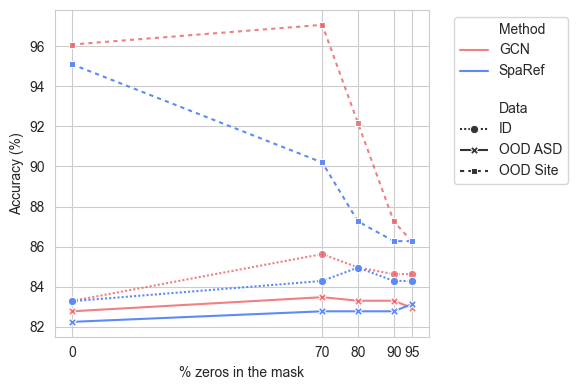

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

metric = 'Accuracy'  # The metric to plot

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Remove the StdAcc rows
df_plot = df[df['Data'] != 'StdAcc']

cp = {'red': (0.922, 0.376, 0.396, 0.8),
                 'lilac': (0.671, 0.565, 0.957, 1),
                    'blue': (0.369, 0.537, 0.973, 1),
                    'mint' : (0.298, 0.694, 0.69, 1),
                    'green': (0.655, 0.875, 0.553, 1),
                    'orange': (0.996, 0.533, 0.333, 1),
                 }

colors = {'GCN': cp['red'], 'SpaRef': cp['blue']}
#colors = {'Mask-GNN': cp['red'], 'LASSO': cp['blue'], 'ElasticNet': cp['green'], 'xGW-GAT': cp['orange'], 'SpaRef': cp['lilac']}
line_styles = {'ID': (1, 1), 'OOD Site': (2, 2), 'OOD ASD': (1, 0)}
#sns_plot = sns.lineplot(data=plotting_df, x='Epoch', y=metric, hue='Method', style='Dataset', dashes=line_styles)

sns.lineplot(data=df_plot, x='Zeros', y=metric, hue='Method', style='Data', dashes=line_styles, palette=colors, errorbar='sd', markers=True)    
#sns.scatterplot(data=df, x='Threshold', y=metric, hue='Method', palette=colors, markers=True)

#sns.lineplot(data=df, x='Threshold', y='B.Acc', hue='Method', style='Dataset')
ax = plt.gca()

plt.xlabel('% zeros in the mask')
plt.ylabel(metric + ' (%)')

# Place the legend outside the top right corner of the plot
handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from one of the subplots
labels = ['\n' + label if label in ['Data'] else label for label in labels]
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1))

# Define static tick marks
ax.set_xticks([0, 70, 80, 90, 95])

# Adjust figure size and layout
plt.gcf().set_size_inches(8, 4)  # Set the figure size (width, height in inches)
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the padding of the figure. rect=[left, bottom, right, top] in normalized figure coordinates.

plt.show()

#output_file = os.path.join(exps_path, f"multiple_thresholds_{metric}.svg")
#plt.savefig(output_file, bbox_inches='tight')